Testing the effect of decorrelating after larger intervals

In [20]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from node_perturbation.node_perturbation import NPLinear
from node_perturbation.utils import np_train
from decorrelation.utils import decor_train
from decorrelation.decorrelation import Decorrelation, DecorLinear
import matplotlib.pyplot as plt
import argparse

import cProfile
import pstats
from torch.profiler import profile, record_function, ProfilerActivity

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [21]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5), (0.5)),
        torch.flatten # for input to linear layer
        ])

train_data = MNIST(root='~/Data', train=True, download=True, transform=transform)
train_data = Subset(train_data, np.random.permutation(len(train_data.data))[:1000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [26]:
args = argparse.Namespace(lr=1e-3, decor_lr=1e-1, bias_lr=1e-5, kappa=0.5, epochs=20)

class Model(nn.Sequential):
    def __init__(self, in_features, args):
        super().__init__(DecorLinear(in_features, 100, decor_lr=args.decor_lr, bias_lr=args.bias_lr, kappa=args.kappa))

    def forward(self, x):
        return super().forward(x.view(len(x), -1))
    
lossfun = torch.nn.CrossEntropyLoss().to(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
model = Model(784, args).to(device)

res = decor_train(args, model, lossfun, train_loader, device, decorrelate=False)
Lbp = res[1]

intervals = np.arange(1, 10, 1)
Ls = []  
for i, interval in enumerate(intervals):

    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    model = Model(784, args).to(device)

    res = decor_train(args, model, lossfun, train_loader, device, interval=interval)
    Ls.append(res[1])

epoch 0  	time:0.000 s	bp loss: 4.921571	decorrelation loss: 0.000000
epoch 1  	time:0.157 s	bp loss: 2.442935	decorrelation loss: 0.000000
epoch 2  	time:0.147 s	bp loss: 1.363612	decorrelation loss: 0.000000
epoch 3  	time:0.145 s	bp loss: 1.035081	decorrelation loss: 0.000000
epoch 4  	time:0.149 s	bp loss: 0.846900	decorrelation loss: 0.000000
epoch 5  	time:0.155 s	bp loss: 0.737528	decorrelation loss: 0.000000
epoch 6  	time:0.158 s	bp loss: 0.650185	decorrelation loss: 0.000000
epoch 7  	time:0.158 s	bp loss: 0.595084	decorrelation loss: 0.000000
epoch 8  	time:0.156 s	bp loss: 0.555518	decorrelation loss: 0.000000
epoch 9  	time:0.148 s	bp loss: 0.523531	decorrelation loss: 0.000000
epoch 10 	time:0.152 s	bp loss: 0.493522	decorrelation loss: 0.000000
epoch 11 	time:0.157 s	bp loss: 0.459374	decorrelation loss: 0.000000
epoch 12 	time:0.157 s	bp loss: 0.429840	decorrelation loss: 0.000000
epoch 13 	time:0.153 s	bp loss: 0.409111	decorrelation loss: 0.000000
epoch 14 	time:0.145

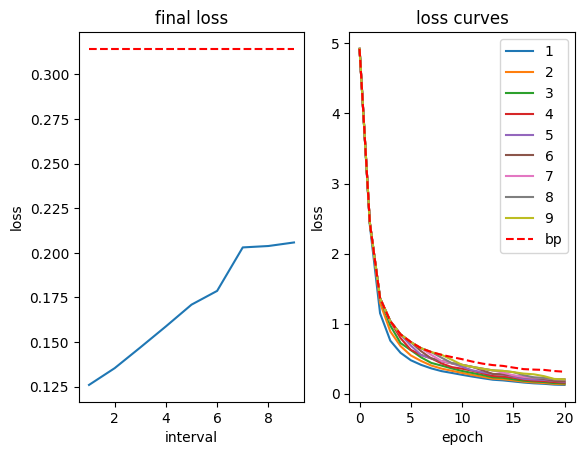

In [27]:
plt.subplot(1,2,1)
plt.plot(intervals, [L[-1] for L in Ls])
plt.plot([intervals[0], intervals[-1]], [Lbp[-1], Lbp[-1]], 'r--')
plt.xlabel('interval')
plt.ylabel('loss');
plt.title('final loss')
plt.subplot(1,2,2)
[plt.plot(L) for L in Ls]
plt.plot(Lbp, 'r--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss curves')
plt.legend([str(interval) for interval in intervals] + ['bp']);